In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Track data loading
import psutil
import time

# Save&Load results
import pickle

In [2]:
# Get RAM information
total_ram = psutil.virtual_memory().total / (1024 ** 3)

print(f"Total RAM: {total_ram:.2f} GB")

Total RAM: 375.90 GB


# 1. Import Dataset

In [3]:
file_path = 'Data/covid19_infodemic_RT_en_1584482894_1686211361_filtered_sorted.dat'

num_rows = sum(1 for line in open(file_path))

In [4]:
num_rows 

114161884

- **Header Data**

Header data is stored in this dataset in the final row.

In [5]:
data_header = np.loadtxt(file_path, dtype = 'str', delimiter = '|', skiprows = num_rows - 1, max_rows = 1)

In [6]:
data_header

array(['tweetID', 'tweetTimestamp', 'tweetType', 'fromUserID',
       'fromUserIsBot', 'fromUserIsVerified', 'fromUserFollowers',
       'fromUserFriends', 'toUserID', 'toUserIsBot', 'toUserIsVerified',
       'toUserFollowers', 'toUserFriends', 'newsCategory'], dtype='<U18')

We manually clarify content in each column sequentially (14 columns in total):

- **Col 0 - 2**: 'tweetID', 'tweetTimestamp', 'tweetType';
- **Col 3 - 7**: 'fromUserID', 'fromUserIsBot', 'fromUserIsVerified', 'fromUserFollowers', 'fromUserFriends'; 
- **Col 8 - 12**: 'toUserID', 'toUserIsBot', 'toUserIsVerified', 'toUserFollowers', 'toUserVerified';
- **Col 13**: 'newsCategory'

Meanwhile, we skip this ending row when loading the dataset in the following.

- **Data Sample Line**

In [7]:
data_line_sample = np.loadtxt(file_path, dtype = 'str', delimiter = '|', max_rows = 1)

In [8]:
data_line_sample

array(['1240052352247197699', '1584482894.0', 'RT', 'HmmBee', '0', '0',
       '286', '571', 'jacobinmag', '1', '1', '263225', '63', 'POLITICAL'],
      dtype='<U19')

We assign data separately to variables 'data_str' and 'data_int' to avoid excessive RAM consumption associated with importing the entire dataset as 'string' type.

- **data_str**: tweetType, fromUserID, toUserID, newsCategory

In [9]:
st = time.time()

data_str = np.loadtxt(file_path, max_rows = num_rows - 1, dtype = 'str', delimiter = '|', usecols = (2, 3, 8, 13))

et = time.time()
elapsed_time = et - st

print('Execution time:', elapsed_time/60, 'mins')
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

Execution time: 3.078679116566976 mins
RAM memory % used: 9.9
RAM Used (GB): 36.893618176


In [10]:
np.shape(data_str)

(114161883, 4)

- **data_int**: 'tweetID', 'tweetTimestamp', 'fromUserIsBot', 'fromUserIsVerified', 'fromUserFollowers', 'fromUserFriends', 'toUserIsBot', 'toUserIsVerified', 'toUserFollowers', 'toUserFriends'

In [11]:
st = time.time()

data_int = np.loadtxt(file_path, max_rows = num_rows - 1, dtype = np.int64, delimiter = "|", usecols = (0,1,4,5,6,7,9,10,11,12))

et = time.time()
elapsed_time = et - st

print('Execution time:', elapsed_time/60, 'mins')
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

Execution time: 1.5398907303810119 mins
RAM memory % used: 12.2
RAM Used (GB): 46.046941184


In [12]:
np.shape(data_int)

(114161883, 10)

# 2. Data Cleaning

- **repeated tweetIDs**: Remove data lines with repeated tweetIDs (0.25%)

In [17]:
index_retain1 = np.unique(data_int[:, 0], return_index=True)[1]

In [18]:
len(data_int[:, 0]) - len(index_retain1), 1 - len(index_retain1)/len(data_int[:, 0])

(296078, 0.0025934926108392986)

In [19]:
index_retain1

array([        0,         1,         2, ..., 114161880, 114161881,
       114161882])

- **newsCategory**: there are 189,355 data lines (0.16%) with newsCateogry "" (i.e., empty). "NA" refers to retweets that contain URLs but not included in our URLs database. 

In [49]:
len(np.where(data_str[:, -1] == "")[0]), len(np.where(data_str[:, -1] == "")[0])/len(data_str[:, -1])

(189355, 0.001658653440395688)

In [48]:
#len(np.where(data_str[:, -1] == "NA")[0]), len(np.where(data_str[:, -1] == "NA")[0])/len(data_str[:, -1])

(29710400, 0.260247984872499)

In [56]:
#index_remove2 = np.union1d(np.where(data_str[:, -1] == "")[0], np.where(data_str[:, -1] == "NA")[0])

In [77]:
index_remove2 = np.where(data_str[:, -1] == "")[0]

In [78]:
len(index_remove2), len(index_remove2)/len(data_str[:, -1])

(189355, 0.001658653440395688)

In [79]:
all_index = np.arange(0, len(data_str[:, -1]), 1)
mask = np.isin(all_index, index_remove2)
index_retain2 = all_index[~mask]

In [80]:
index_retain2

array([        0,         1,         2, ..., 114161880, 114161881,
       114161882])

- **fromUserFollowers, fromUserFriends**: there is a single data line where both fromUserFollowers and fromUserFriends are recorded as -1, corresponding to tweetID 1445440938491396098

In [81]:
index_remove3 = np.where(data_int[:, 0] == 1445440938491396098)[0]

In [82]:
len(index_remove3), len(index_remove3)/len(data_str[:, -1])

(1, 8.759491116662818e-09)

In [83]:
mask = np.isin(all_index, index_remove3)
index_retain3 = all_index[~mask]

In [84]:
index_retain3

array([        0,         1,         2, ..., 114161880, 114161881,
       114161882])

**Find Intersection**

In [85]:
index_retain = np.intersect1d(index_retain1, np.intersect1d(index_retain2, index_retain3))

In [33]:
index_retain

array([        0,         1,         2, ..., 114161880, 114161881,
       114161882])

In [86]:
len(index_retain), len(index_retain)/len(all_index)

(113685100, 0.9958236235469241)

## 2.1. Save&Load Retained Index

- Save

In [87]:
with open('Data/dataCleaning_indexRetain.pickle', 'wb') as file:
    pickle.dump(index_retain, file)

- Load

In [34]:
with open('Data/dataCleaning_indexRetain.pickle', 'rb') as file:
    index_retain =  pickle.load(file)

# 3. SummaryStats

## 3.1. Data Timeframe

Start from 7 March 2020, collected second by second

In [89]:
min(data_int[:, 1][index_retain]), max(data_int[:, 1][index_retain])

(1584482894, 1676174362)

In [90]:
(max(data_int[:, 1][index_retain]) - min(data_int[:, 1][index_retain]))/(24*60*60)

1061.2438425925925

In [91]:
from datetime import datetime, timedelta

# Starting date
start_date = datetime(2020, 3, 7)

# Calculate the date 1061 days later
result_date = start_date + timedelta(days=1061)

print("Date 1061 days after March 7, 2020 is:", result_date.strftime("%Y-%m-%d"))

Date 1061 days after March 7, 2020 is: 2023-02-01


## 3.2. News Category

In [18]:
newsCategory = np.unique(data_str[:, -1][index_retain])
newsCategory

array(['CLICKBAIT', 'CONSPIRACY/JUNKSCI', 'FAKE/HOAX', 'MSM', 'NA',
       'OTHER', 'POLITICAL', 'SATIRE', 'SCIENCE', 'SHADOW'], dtype='<U18')

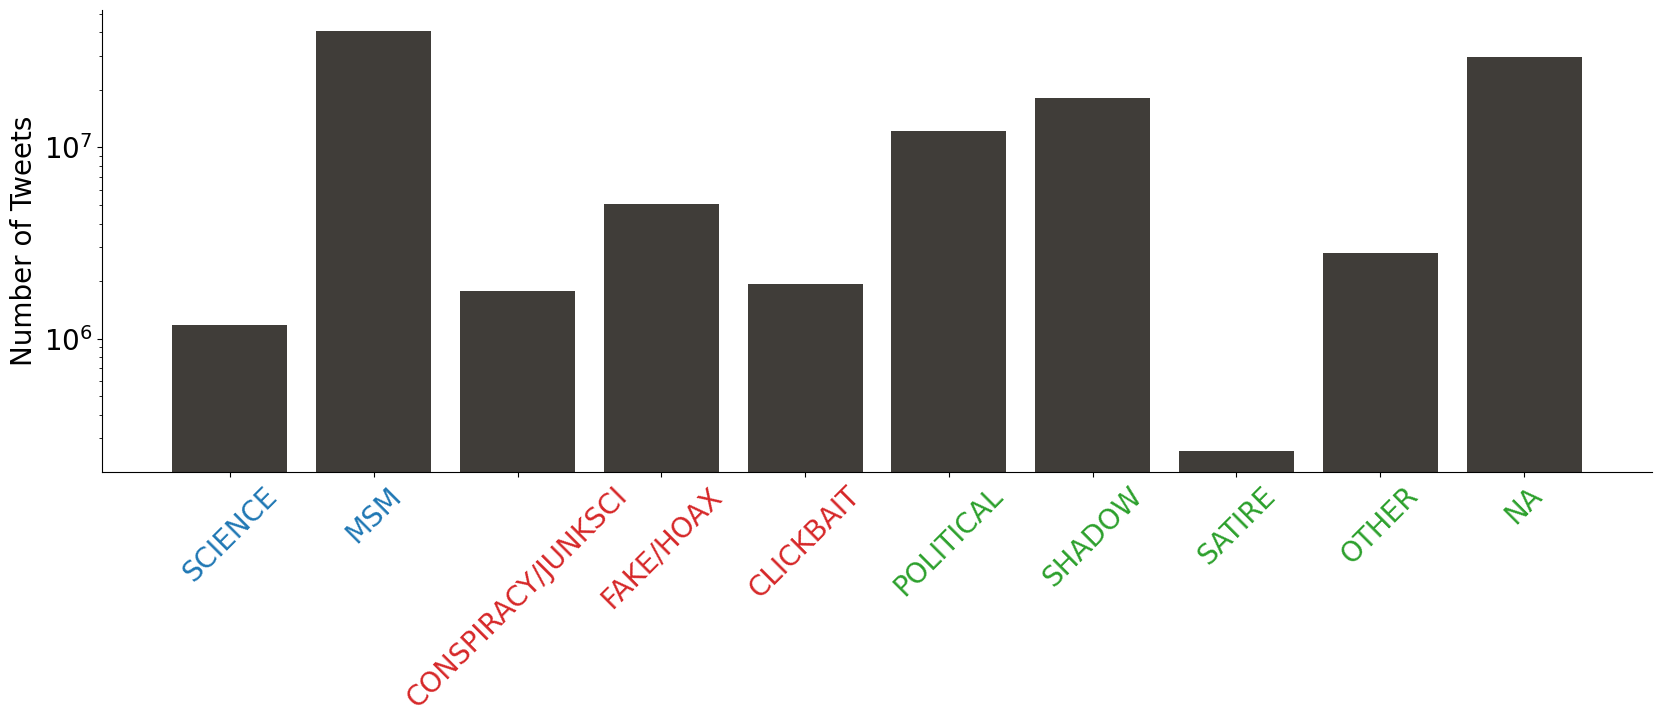

In [15]:
# Count the occurrences of each category
category_counts = {category: np.count_nonzero(data_str[index_retain, -1] == category) for category in newsCategory}

# Bar plot with switching sequence

fig, axs = plt.subplots(figsize=(20,6))

X = ['SCIENCE', 'MSM', 'CONSPIRACY/JUNKSCI', 'FAKE/HOAX', 'CLICKBAIT', 'POLITICAL', 'SHADOW', 'SATIRE', 'OTHER', 'NA']
axs.bar(X, [category_counts[X[i]] for i in range(len(X))], color = '#403d39')

plt.xticks(fontsize = 20, rotation = 45); plt.yticks(fontsize = 20)
plt.yscale('log') 
plt.ylabel("Number of Tweets", fontsize = 20)


my_colors = ['tab:blue']*2 + ['tab:red']*3 + ['tab:green']*5

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

In [103]:
category_counts

{'NA': 29615585,
 'OTHER': 2793839,
 'SHADOW': 18120185,
 'CONSPIRACY/JUNKSCI': 1783052,
 'MSM': 40711848,
 'SCIENCE': 1183951,
 'SATIRE': 258135,
 'CLICKBAIT': 1926902,
 'FAKE/HOAX': 5088717,
 'POLITICAL': 12202886}

- scientific

In [110]:
sci_sum = category_counts['SCIENCE'] + category_counts['MSM']

In [111]:
sci_sum, sci_sum/len(data_str[:, -1][index_retain])

(41895799, 0.3685249782073464)

- fake

In [112]:
fake_sum = category_counts['CONSPIRACY/JUNKSCI'] + category_counts['FAKE/HOAX'] + category_counts['CLICKBAIT']

In [113]:
fake_sum, fake_sum/len(data_str[:, -1][index_retain])

(8798671, 0.07739511158454362)

- uncertain

In [114]:
uncertain_sum = len(data_str[:, -1][index_retain]) - sci_sum - fake_sum

In [115]:
uncertain_sum, uncertain_sum/len(data_str[:, -1][index_retain])

(62990630, 0.55407991020811)

### 3.2.1. Encoding & Decoding

- Encode tweetNewsCategory into integers (so as to reduce computation time)

In [19]:
newsCateogry_dict_encode = {newsCategory[i]:i for i in range(len(newsCategory))}

In [20]:
newsCateogry_dict_encode

{'CLICKBAIT': 0,
 'CONSPIRACY/JUNKSCI': 1,
 'FAKE/HOAX': 2,
 'MSM': 3,
 'NA': 4,
 'OTHER': 5,
 'POLITICAL': 6,
 'SATIRE': 7,
 'SCIENCE': 8,
 'SHADOW': 9}

- Decode

In [21]:
newsCateogry_dict_decode = {i:newsCategory[i] for i in range(len(newsCategory))}

In [22]:
newsCateogry_dict_decode

{0: 'CLICKBAIT',
 1: 'CONSPIRACY/JUNKSCI',
 2: 'FAKE/HOAX',
 3: 'MSM',
 4: 'NA',
 5: 'OTHER',
 6: 'POLITICAL',
 7: 'SATIRE',
 8: 'SCIENCE',
 9: 'SHADOW'}

In [56]:
newsCateogry_dict_generalised_code = {3: 0,  # sciInfo
                                      8: 0,
                                      1: 1,  # misInfo
                                      2: 1,
                                      7: 1,
                                      0: 2,  # undecidedInfo
                                      4: 2,
                                      5: 2, 
                                      6: 2,
                                      9: 2,
                                     }

- Save & Load

In [57]:
with open('Graphs/newsCateogry_dict_decode.pickle', 'wb') as file:
    pickle.dump(newsCateogry_dict_decode, file)
with open('Graphs/newsCateogry_dict_generalised_code.pickle', 'wb') as file:
    pickle.dump(newsCateogry_dict_generalised_code, file)

In [55]:
with open('Graphs/newsCateogry_dict_decode.pickle', 'rb') as file:
    newsCateogry_dict_decode =  pickle.load(file)

## 3.3. Users

In [37]:
unique_users = np.union1d(data_str[:, 1][index_retain], data_str[:, 2][index_retain])

In [38]:
len(unique_users)

13948159

### 3.3.1. Encoding & Decoding

- Encode users' ID into integers (so as to reduce computation time)

In [41]:
user_dict_encode = {unique_users[i]:i for i in range(len(unique_users))}

- Decode

In [47]:
user_dict_decode = {i:unique_users[i] for i in range(len(unique_users))}

- Save & Load

In [51]:
with open('Graphs/user_dict_decode.pickle', 'wb') as file:
    pickle.dump(user_dict_decode, file)

In [52]:
with open('Graphs/user_dict_decode.pickle', 'rb') as file:
    user_dict_decode =  pickle.load(file)

In [53]:
user_dict_decode[10645250], user_dict_decode[6827149] # example

('ladbible', 'WhiteHouse')